In [1]:
library(tidyverse)
library(survival)
library(survminer)
library(DESeq2)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: ggpubr
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, 

In [2]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_list <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

In [3]:
i <- 1

In [114]:
sig_deg_df <- read_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[i], "_sig_DESeq_results_xref_matrisome.tsv"))
matrisome_sig_deg_df <- sig_deg_df %>%
    dplyr::filter(in_matrisome == TRUE)
coldata_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/coldata.tsv"))

Parsed with column specification:
cols(
  geneID = col_character(),
  baseMean = col_double(),
  log2FoldChange = col_double(),
  lfcSE = col_double(),
  stat = col_double(),
  pvalue = col_double(),
  padj = col_double(),
  in_matrisome = col_logical(),
  division = col_character(),
  category = col_character(),
  gene_name = col_character(),
  synonyms = col_character(),
  hgnc_ids = col_double(),
  hgnc_ids_links = col_double(),
  uniprot_ids = col_character(),
  refseq_ids = col_character(),
  orthology = col_character(),
  notes = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  data_source = col_character()
)


In [4]:
matrisome_df <- rutils::load_matrisome_df(matrisome_list)
survival_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/survival_data.tsv")) %>%
    mutate(vital_status_num = case_when(
        vital_status == "Dead" ~ 1,
        vital_status == "Alive" ~ 0
    )) %>%
    dplyr::select(sample_name, vital_status_num, everything(), -vital_status) %>%
    dplyr::rename(vital_status = vital_status_num) %>%
    dplyr::filter(!is.na(survival_time), !is.na(vital_status))
survival_cols <- colnames(survival_df)
head(survival_df)
nrow(survival_df)

Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `Gene Name` = col_character(),
  Synonyms = col_character(),
  HGNC_IDs = col_double(),
  `HGNC_IDs Links` = col_double(),
  UniProt_IDs = col_character(),
  Refseq_IDs = col_character(),
  Orthology = col_character(),
  Notes = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  survival_time = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race_american_indian_or_alaska_native = col_double(),
  race_asian = col_double(),
  race_black_or_african_american = col_double(),
  race_native_hawaiian_or_other_pacific_islander = col_double(),
  race_not_reported = col_double(),
  race_white = col_double(),
  

sample_name,vital_status,days_to_last_follow_up,days_to_death,survival_time,age_at_diagnosis,age_at_index,height,weight,bmi,race_american_indian_or_alaska_native,race_asian,race_black_or_african_american,race_native_hawaiian_or_other_pacific_islander,race_not_reported,race_white,ethnicity_hispanic_or_latino,ethnicity_not_hispanic_or_latino,ethnicity_not_reported
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-C5-A1BF-01B-11R-A13Y-07,1,NA,570,570,16975,46,NA,76,NA,0,0,0,0,0,1,0,0,1
TCGA-MU-A51Y-01A-11R-A26T-07,0,854,NA,854,10199,27,NA,31,NA,0,0,0,0,0,1,0,0,1
TCGA-EK-A2RM-01A-21R-A18M-07,0,50,NA,50,14842,40,167,105,37.64925,0,0,0,0,0,1,0,1,0
TCGA-Q1-A73P-01A-11R-A32P-07,0,483,NA,483,16450,45,173,82,27.39818,0,0,0,0,0,1,0,1,0
TCGA-C5-A8YT-01A-11R-A37O-07,1,186,633,633,13253,36,NA,NA,NA,0,0,0,0,0,1,0,1,0
TCGA-C5-A2LZ-01A-11R-A213-07,1,NA,3046,3046,24059,65,163,85,31.99217,0,0,0,0,0,1,0,1,0


[1] 259

In [5]:
race_cols <- survival_cols[grepl("^race_", survival_cols)]
ethnicity_cols <- survival_cols[grepl("^ethnicity_", survival_cols)]
covariate_cols <- c("age_at_diagnosis", "bmi", race_cols, ethnicity_cols)
dep_cols <- c("vital_status", "survival_time")
filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols, covariate_cols))) %>%
    # For now, drop rows with NA -- rethink this later as expand number of features
    dplyr::filter(rowSums(is.na(.)) == 0)

In [30]:
counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[i], "/counts.tsv")) %>%
    dplyr::rename(geneID = Hugo_Symbol) %>%
    dplyr::select(-Entrez_Gene_Id) %>%
    dplyr::mutate_if(is.numeric, round, 0) %>%
    dplyr::filter(geneID %in% matrisome_df$gene_symbol)    # Only care about matrisome genes

# Match up columns of counts with rows of survival data & only include samples present in survival data
survival_counts_df <- counts_df[, c("geneID", filtered_survival_df$sample_name)] %>%
    dplyr::filter(rowSums(.[, -1]) > 0)    # Ignore genes which are unexpressed in this group
survival_counts <- as.matrix(survival_counts_df %>% column_to_rownames(var = "geneID"))
norm_survival_counts <- varianceStabilizingTransformation(as.matrix(survival_counts_df[, -1]))
rownames(norm_survival_counts) <- survival_counts_df$geneID

genes_of_interest <- rownames(norm_survival_counts)

Parsed with column specification:
cols(
  .default = col_double(),
  Hugo_Symbol = col_character()
)
See spec(...) for full column specifications.
converting counts to integer mode


In [31]:
nrow(filtered_survival_df)
nrow(filtered_survival_df) / nrow(survival_df)
# A row of survival_counts should be usable as a column in filtered_survival_df
all(colnames(survival_counts) == filtered_survival_df$sample_name)

[1] 217

[1] 0.8378378

[1] TRUE

# Test significance of including a gene

In [103]:
# singular.ok = TRUE because race & ethnicity are one-hot encodings, so
# some columns are certain to be linear combinations of others
null_model_formula_chr <- paste0("Surv(survival_time, vital_status) ~ ", paste(covariate_cols, collapse = " + "))
survival_fit_null <- coxph(as.formula(null_model_formula_chr), data = filtered_survival_df, singular.ok = TRUE)
gene_model_formula_chr <- paste0(null_model_formula_chr, " + gene")
gene_pvals <- c()
gene_coeffs <- c()

for (g in genes_of_interest) {
    survival_fit_gene <- coxph(as.formula(gene_model_formula_chr), data = filtered_survival_df %>% dplyr::mutate(gene = norm_survival_counts[g, ]), singular.ok = TRUE)
    anova_res <- anova(survival_fit_null, survival_fit_gene, test = "LRT")
    gene_pvals <- c(gene_pvals, anova_res[["P(>|Chi|)"]][2])
    gene_coeffs <- c(gene_coeffs, survival_fit_gene$coefficients[["gene"]])
}

Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  12 ; coefficient may be infinite. ”Warning message in fitter(X, Y, istrat, offset, init, control, weights = wei

In [105]:
cox_regression_df <- tibble("geneID" = genes_of_interest, "gene_pval" = gene_pvals, "gene_coeff" = gene_coeffs)
sig_cox_regression_df <- cox_regression_df %>%
    dplyr::filter(gene_pval < 0.05)

Saving 6.67 x 6.67 in image


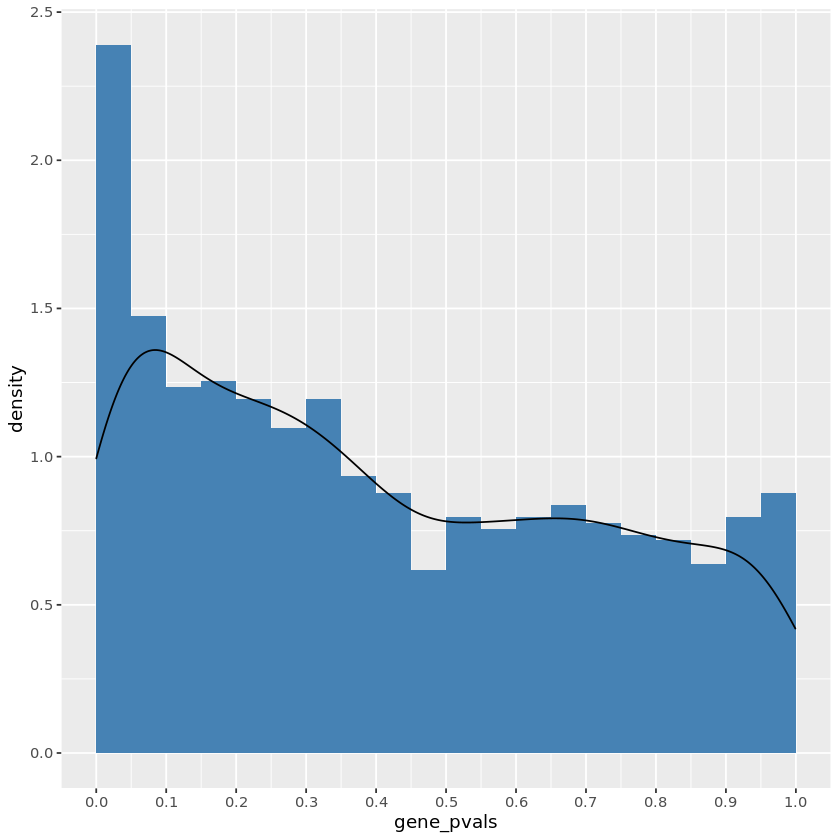

In [228]:
ggplot() +
    geom_histogram(aes(x = gene_pvals, y = ..density..), data = cox_regression_df, binwidth = 0.05, boundary = 0, fill = "steelblue") +
    geom_density(aes(x = gene_pvals), data = cox_regression_df) +
    scale_x_continuous(breaks = seq(from = 0, to = 1, by = 0.1))
ggsave(paste0(dirs$figures_dir, "/", unified_dsets[i], "_predictive_pval_density.png"), last_plot())

In [109]:
length(matrisome_sig_deg_df$geneID)
length(sig_cox_regression_df$geneID)
length(union(matrisome_sig_deg_df$geneID, sig_cox_regression_df$geneID))

[1] 559

[1] 120

[1] 609

In [164]:
hm_df <- counts_df %>%
    dplyr::select(geneID) %>%
    dplyr::mutate(
        deg = ifelse(geneID %in% matrisome_sig_deg_df$geneID, 1, 0),
        pred = ifelse(geneID %in% sig_cox_regression_df$geneID, 1, 0)
    ) %>%
    dplyr::mutate(
        both = ifelse(deg & pred, 1, 0)
    )
nrow(hm_df)
head(hm_df)

[1] 1008

geneID,deg,pred,both
<chr>,<dbl>,<dbl>,<dbl>
PGF,0,0,0
TIMP4,1,0,0
C1QTNF6,0,0,0
TNC,0,1,0
PRL,1,0,0
OGN,1,0,0


In [166]:
hm_pivot_df <- hm_df %>%
    pivot_longer(cols = deg:both, names_to = "test")
hm_pivot_df$test = factor(hm_pivot_df$test, levels = c("deg", "pred", "both"))
hm_pivot_df$value = factor(hm_pivot_df$value, levels = c("0", "1"))

head(hm_pivot_df)
nrow(hm_pivot_df)

geneID,test,value
<chr>,<fct>,<fct>
PGF,deg,0
PGF,pred,0
PGF,both,0
TIMP4,deg,1
TIMP4,pred,0
TIMP4,both,0


[1] 3024

Saving 6.67 x 6.67 in image


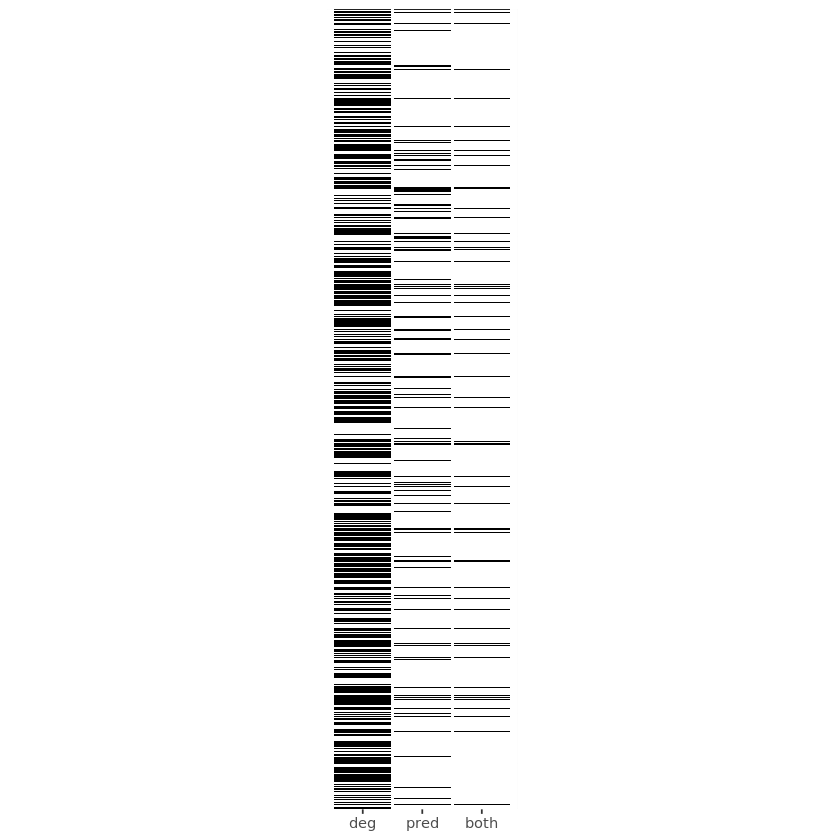

In [229]:
ggplot() +
    geom_tile(aes(x = test, y = geneID, fill = value), data = hm_pivot_df, width = 0.95) +
    scale_fill_manual(values = c("white", "black")) +
    theme(
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        legend.position = "None"
    ) +
    coord_equal(ratio = 1/75)
ggsave(paste0(dirs$figures_dir, "/", unified_dsets[i], "_matrisome_DEG_predictive_heatmap.png"), last_plot())

In [237]:
matrisome_df %>%
    dplyr::filter(gene_symbol %in% intersect(matrisome_sig_deg_df$geneID, sig_cox_regression_df$geneID)) %>%
    write_tsv(paste0(dirs$analysis_dir, "/", unified_dsets[i], "_DE_and_predictive.tsv"))